In [1]:
# Imports
import pandas as pd
import numpy as np
import os

In [2]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

# Preprocessing

In [3]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [4]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import gc

torch.cuda.empty_cache()
gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Extracting the words_str column and splitting into training and validation sets
# Extracting the words_str column and labels
words_str_data = df['words_str'].values
labels = df['score_compound'].values

X_train_words_str, X_val_words_str, y_train, y_val = train_test_split(words_str_data, labels, test_size=0.2, random_state=42)

# Limiting the vocabulary size in CountVectorizer
max_features = 5000  # Adjust this value as needed
vectorizer = CountVectorizer(max_features=max_features)
X_train_tokens = vectorizer.fit_transform(X_train_words_str)
X_val_tokens = vectorizer.transform(X_val_words_str)

# Converting the tokenized data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tokens.toarray()).float()
X_val_tensor = torch.tensor(X_val_tokens.toarray()).float()

# Padding the sequences
X_train_padded = pad_sequence(X_train_tensor, batch_first=True, padding_value=0).to(device)
X_val_padded = pad_sequence(X_val_tensor, batch_first=True, padding_value=0).to(device)

# Converting labels to PyTorch tensors and moving to GPU
y_train_tensor = torch.tensor(y_train).float().to(device)
y_val_tensor = torch.tensor(y_val).float().to(device)

# Displaying the shape of the preprocessed data
X_train_padded.shape, X_val_padded.shape, y_train_tensor.shape, y_val_tensor.shape

(torch.Size([6400, 5000]),
 torch.Size([1600, 5000]),
 torch.Size([6400]),
 torch.Size([1600]))

# LSTM

In [6]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [7]:
class LSTM_MLP_NN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_MLP_NN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last hidden state
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [8]:
# Initialization functions
def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
            elif 'weight_hh' in name:
                nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
            elif 'bias' in name:
                param.data.fill_(0)


# Helper function to compute RMSE
def compute_rmse(y_true, y_pred):
    mse_loss = torch.nn.MSELoss()
    mse = mse_loss(y_true, y_pred)
    return torch.sqrt(mse)

In [9]:
# Hyperparameters for the LSTM model
embedding_dim = 80  
hidden_dim = 50     
learning_rate = 0.00000001
epochs = 10000
batch_size = 32


# Initialize the model using max_features as the vocab_size
model_lstm_mlp = LSTM_MLP_NN(max_features, embedding_dim, hidden_dim).to(device)
model_lstm_mlp.apply(init_weights_he)


# Loss (using Huber loss) and optimizer
criterion = nn.HuberLoss().to(device)
optimizer = torch.optim.AdamW(model_lstm_mlp.parameters(), lr=learning_rate)

# DataLoader for batching
train_data = DataLoader(list(zip(X_train_padded.long(), y_train_tensor)), batch_size=batch_size, shuffle=True)

# Lists to store training and validation losses and RMSE
training_losses = []
validation_losses = []
training_rmse = []
validation_rmse = []

# Training loop
for epoch in range(epochs):
    model_lstm_mlp.train()  # Set the model to training mode
    epoch_training_losses = []  # Store training losses for each batch
    for batch_idx, (X_batch, y_batch) in enumerate(train_data):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model_lstm_mlp(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        epoch_training_losses.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model_lstm_mlp.eval()
    with torch.no_grad():
        val_outputs = model_lstm_mlp(X_val_padded.long().to(device)).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor.to(device))

    # Calculate RMSE for training and validation
    train_rmse_value = compute_rmse(outputs, y_batch)
    val_rmse_value = compute_rmse(val_outputs, y_val_tensor.to(device))

    # Append to lists
    training_losses.append(sum(epoch_training_losses) / len(epoch_training_losses))
    validation_losses.append(val_loss.item())
    training_rmse.append(train_rmse_value.item())
    validation_rmse.append(val_rmse_value.item())

    # Print progress
    # If epoc is less then 100 then print every 10th epoch
    if epoch < 100 and epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse_value.item():.4f}, Validation RMSE: {val_rmse_value.item():.4f}')
    # If epoch is greater then 100 but less than 500  then print every 50 th epoch
    elif epoch >= 100 and epoch < 500 and epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse_value.item():.4f}, Validation RMSE: {val_rmse_value.item():.4f}')
    # If epoch is greater than 500 and less than 1000 then print every 100th epoch
    elif epoch >= 500 and epoch < 1000 and epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse_value.item():.4f}, Validation RMSE: {val_rmse_value.item():.4f}')
    # If epoch is greater than 1000 and less tan 10000 then print every 200th epoch
    elif epoch >= 1000 and epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training RMSE: {train_rmse_value.item():.4f}, Validation RMSE: {val_rmse_value.item():.4f}')


print("Training completed.")

Epoch [1/10000], Training Loss: 0.1240, Validation Loss: 0.1244, Training RMSE: 0.4980, Validation RMSE: 0.4988


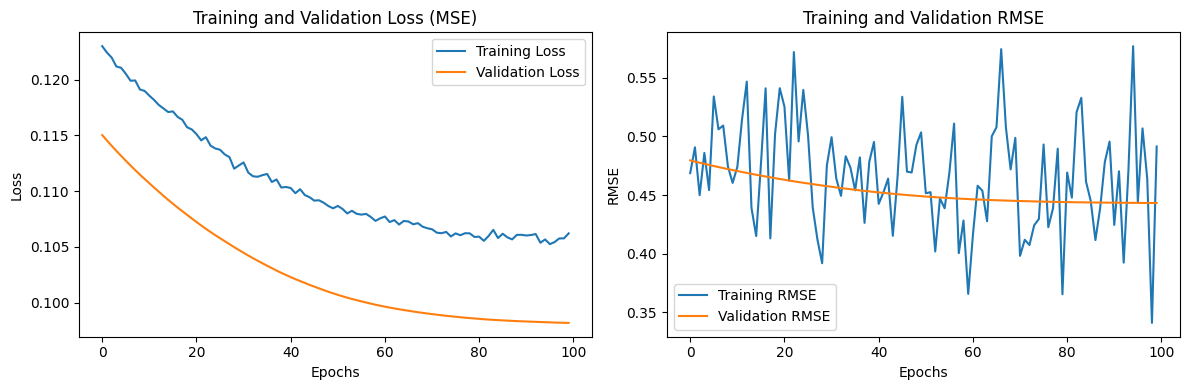

In [ ]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(training_rmse, label='Training RMSE')
plt.plot(validation_rmse, label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()
